读取使用的时间机器数据集：

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

初始化模型参数

In [25]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # 我们从标准差为0.01的高斯分布中提取权重
    def normal(shape):
        
        # 个人错误tips：
        #   在第一次我自己编程的时候 我写成了torch.zeros 导致所有的参数初始值全为0
        #   相当于 让0求梯度求偏导，无法训练

        return torch.randn(size=shape, device=device) * 0.01
    
    # 将之前的对三个隐藏层参数初始化包装在一起
    def three():
        return (
            normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
            )
    # 更新门 update 参数
    W_xz, W_hz, b_z = three()
    # 重置门 reset  参数
    W_xr, W_hr, b_r = three()
    # 候选隐状态 H   参数
    W_xh, W_hh, b_h = three()

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

定义隐状态的初始化函数init_gru_state。 与init_rnn_state函数一样\
此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [26]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

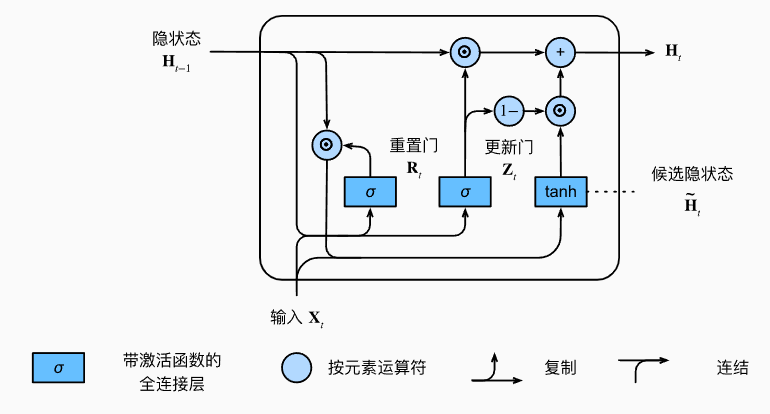

In [1]:
from IPython.display import Image
Image(filename = 'E:\Clancy\Code\动手学深度学习NLP篇\\GRU.png', width=10, height=10)

定义门控循环单元模型

In [27]:
def GRU(inputs, state, params):
    # 去除状态和各类门参数
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state

    output = []
    # "@" = torch.mm [矩阵乘法]
    for X in inputs:
        
        # 将X的规模变为 X ==> [时间步数, 批量大小, 特征向量长度]
        # X = F.one_hot(X.T, self.vocab_size).type(torch.float32)

        # X[32 * 28 ]   32:batch-size   28 :vocab-size
        # W[28 * 256]   28:vocab-size   256:num_hiddens
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)

        # 对于本层的H 若更新门Z趋近于0, 
        # 则更多的会忘记上一层的状态H 而转向更多的保留这一层计算的新H的信息
        H = Z * H + (1 - Z) * H_tilda
        # 输出
        Y = H @ W_hq + b_q

        output.append(Y)
    
    return torch.cat(output, dim=0), (H,)

In [28]:
# class RNNModelScratch:
#     """从零开始实现的循环神经网络模型"""   
#     def __init__(self, vocab_size, num_hiddens, device, 
#                 get_params, init_state, forward_fn):
        
#         self.vocab_size = vocab_size
#         self.num_hiddens = num_hiddens
#         self.params = get_params(vocab_size, num_hiddens, device)
#         self.init_state = init_state
#         self.forward_fn = forward_fn 
    
#     # 此时的X是(批量大小，时间步数)
#     def __call__(self, X, state):

#         # 将X的规模变为 X ==> [时间步数, 批量大小, 特征向量长度]
#         X = F.one_hot(X.T, self.vocab_size).type(torch.float32)

#         # 投入forward_fn 可以得到输出state与更新后的参数params
#         return self.forward_fn(X, state, self.params)

#     def begin_state(self, batch_size, device):
#         return self.init_state(batch_size, self.num_hiddens, device) 

训练和预测的工作方式与55完全相同

perplexity 1.1, 33345.1 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


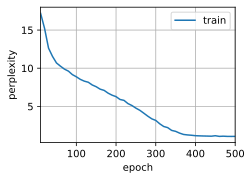

In [29]:
vocab_size = len(vocab)
num_hiddens = 256
device = d2l.try_gpu()


num_epochs = 500
lr = 1

model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, GRU)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)